## 1. Imports e Configuração

In [7]:
from pathlib import Path
import sys

# Descobre a raiz do projeto (pasta que contém "src" e "notebooks")
PROJECT_ROOT = Path.cwd().parent          # se o notebook está em /notebooks
SRC_PATH = PROJECT_ROOT / "src"

if SRC_PATH.exists():
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.append(str(PROJECT_ROOT))
        print(f"📁 Projeto adicionado ao sys.path: {PROJECT_ROOT}")
else:
    raise FileNotFoundError(f"Pasta 'src' não encontrada em: {SRC_PATH}")


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import lightgbm as lgb

# Project modules
from src.features import criar_variaveis_derivadas
from src.config import DATA_PATH, MODELS_PATH, TEXT_PATH, FIGURES_PATH
from src.model_versioning import ModelVersionManager, ModelMetrics, log_evaluation

# Estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Todos os imports carregados com sucesso!")

✅ Todos os imports carregados com sucesso!


## 2. Carregamento e Preparação de Dados

In [9]:
# Carregar dados
df = pd.read_csv(DATA_PATH)

print(f"📊 Dados carregados: {df.shape[0]} registros, {df.shape[1]} variáveis")
print(f"\nPrimeiras linhas:\n{df.head()}")
print(f"\nTipos de dados:\n{df.dtypes}")
print(f"\nValores faltantes:\n{df.isnull().sum().sum()} faltantes no total")

📊 Dados carregados: 10127 registros, 23 variáveis

Primeiras linhas:
   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39

## 3. Engenharia de Features

In [10]:
# Aplicar engenharia de features
df = criar_variaveis_derivadas(df)

print(f"✅ Features criadas: {df.shape[1]} variáveis disponíveis")
print(f"\nNovas colunas: {[col for col in df.columns if col not in ['Attrition_Flag', 'Customer_Age']]}")

✅ Features criadas: 67 variáveis disponíveis

Novas colunas: ['CLIENTNUM', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Ticket_Medio', 'Transacoes_por_Mes', 'Gasto_Medio_Mensal', 'Taxa_Queda_Transacoes', 'Taxa_Queda_Valor', 'Caiu_Transacoes', 'Caiu_Valor', 'Queda_Severa', 'Cliente_Inativo', 'Gasto_Baixo', 'Rotativo_Ratio', 'Disponibilidade_Relativa', 'Utilizacao_Alta', 'Utilizacao_Baixa', 'Sem_Uso_Rotativo'

## 4. Seleção de Features e Preparação da Target

In [11]:
# 12-feature baseline (padrão de produção)
features = [
    'Customer_Age', 'Dependent_count', 'Credit_Limit',
    'Total_Trans_Amt', 'Total_Trans_Ct', 'Ticket_Medio',
    'Gasto_Medio_Mensal', 'Rotativo_Ratio', 'Score_Relacionamento',
    'LTV_Proxy', 'Caiu_Valor', 'Caiu_Transacoes'
]

X = df[features]
y = df["Attrition_Flag"].map({"Attrited Customer": 1, "Existing Customer": 0})

print(f"✅ Features selecionadas: {len(features)}")
print(f"✅ Target (churn): {y.sum()} positivos ({y.sum()/len(y):.1%}) | {len(y)-y.sum()} negativos ({(1-y.sum()/len(y)):.1%})")
print(f"\nDistribuição alvo:\n{y.value_counts(normalize=True).sort_index()}")

✅ Features selecionadas: 12
✅ Target (churn): 1627 positivos (16.1%) | 8500 negativos (83.9%)

Distribuição alvo:
Attrition_Flag
0    0.83934
1    0.16066
Name: proportion, dtype: float64


## 5. Split Treino/Teste com Estratificação

In [12]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantém proporção de churn em treino e teste
)

print(f"✅ Dados divididos com sucesso")
print(f"\nTreino: {len(X_train)} registros")
print(f"  - Churn: {y_train.sum()} ({y_train.sum()/len(y_train):.1%})")
print(f"\nTeste: {len(X_test)} registros")
print(f"  - Churn: {y_test.sum()} ({y_test.sum()/len(y_test):.1%})")

✅ Dados divididos com sucesso

Treino: 8101 registros
  - Churn: 1302 (16.1%)

Teste: 2026 registros
  - Churn: 325 (16.0%)


## 6. Treinamento do Modelo - LightGBM

In [13]:
# Hiperparâmetros otimizados
lgbm_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 4,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'is_unbalanced': True,           # Dados desbalanceados
    'class_weight': 'balanced',       # Estratégia: não usar SMOTE
    'verbose': -1
}

# Treinar modelo
model = lgb.LGBMClassifier(**lgbm_params)
model.fit(X_train, y_train)

print("✅ Modelo LightGBM treinado com sucesso!")
print(f"\nHiperparâmetros: {lgbm_params}")

  File "c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


✅ Modelo LightGBM treinado com sucesso!

Hiperparâmetros: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 31, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'is_unbalanced': True, 'class_weight': 'balanced', 'verbose': -1}


## 7. Avaliação Compreensiva

In [14]:
# Predições
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcular métricas
auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_dict = {
    'auc': auc_score,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

# Exibir resultados
print("="*50)
print("MÉTRICAS DE AVALIAÇÃO")
print("="*50)
print(f"🎯 AUC-ROC:      {auc_score:.4f}")
print(f"🎯 Acurácia:     {accuracy:.4f}")
print(f"🎯 Precisão:     {precision:.4f}")
print(f"🎯 Recall:       {recall:.4f}")
print(f"🎯 F1-Score:     {f1:.4f}")
print("="*50)

MÉTRICAS DE AVALIAÇÃO
🎯 AUC-ROC:      0.9846
🎯 Acurácia:     0.9408
🎯 Precisão:     0.7569
🎯 Recall:       0.9292
🎯 F1-Score:     0.8343


## 8. Validação Cruzada

In [15]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, X_train, y_train,
    cv=cv,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    n_jobs=-1
)

# Resumo de CV
print("\n📊 VALIDAÇÃO CRUZADA (5-fold)")
print(f"AUC-ROC:  {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
print(f"Acurácia: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"Precisão: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"Recall:   {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"F1:       {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")


📊 VALIDAÇÃO CRUZADA (5-fold)
AUC-ROC:  0.9813 (+/- 0.0037)
Acurácia: 0.9337 (+/- 0.0063)
Precisão: 0.7372 (+/- 0.0202)
Recall:   0.9140 (+/- 0.0107)
F1:       0.8161 (+/- 0.0157)


## 9. Análise de Feature Importance

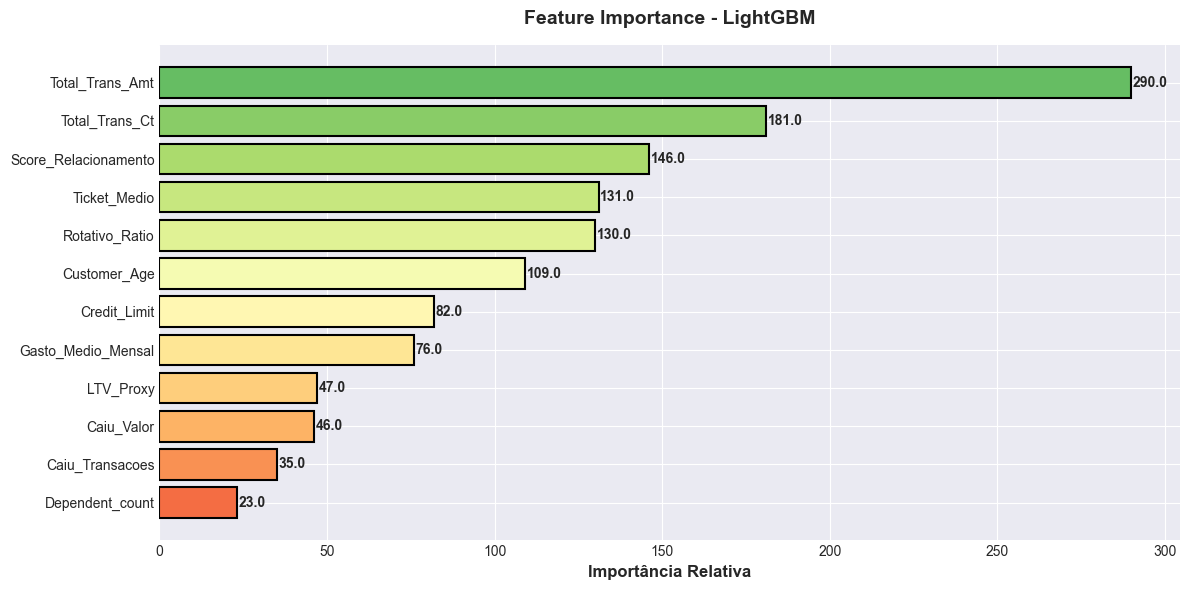


✅ Top 5 Features:
                feature  importance
3       Total_Trans_Amt         290
4        Total_Trans_Ct         181
8  Score_Relacionamento         146
5          Ticket_Medio         131
7        Rotativo_Ratio         130


In [16]:
# Feature importance
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(feature_importance_df)))
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Importância Relativa', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance - LightGBM', fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()

# Adicionar valores
for i, v in enumerate(feature_importance_df['importance']):
    ax.text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "feature_importance_reference.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Top 5 Features:")
print(feature_importance_df.head())

## 10. Matriz de Confusão

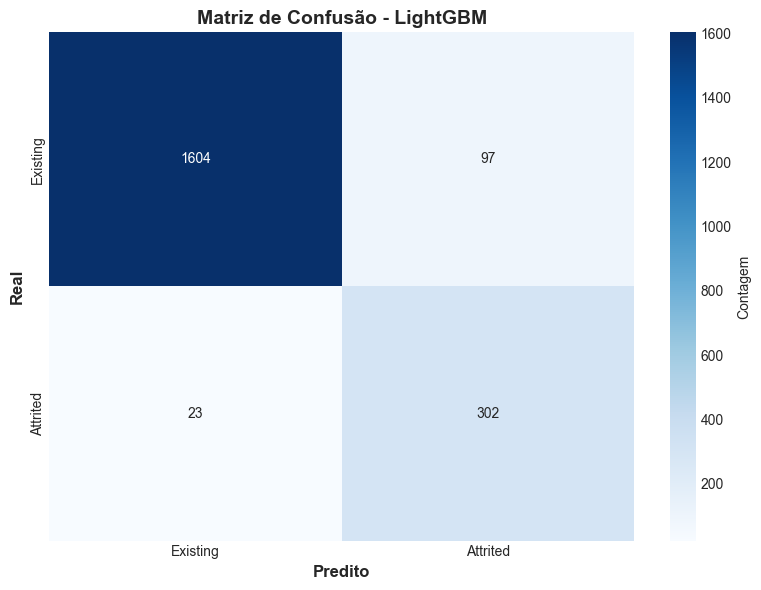


✅ Análise:
  True Negatives (TN):  1604
  False Positives (FP): 97
  False Negatives (FN): 23
  True Positives (TP):  302


In [17]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Existing', 'Attrited'],
            yticklabels=['Existing', 'Attrited'],
            cbar_kws={'label': 'Contagem'})
ax.set_xlabel('Predito', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - LightGBM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "confusion_matrix_reference.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Análise:")
print(f"  True Negatives (TN):  {cm[0,0]}")
print(f"  False Positives (FP): {cm[0,1]}")
print(f"  False Negatives (FN): {cm[1,0]}")
print(f"  True Positives (TP):  {cm[1,1]}")

## 11. Curva ROC

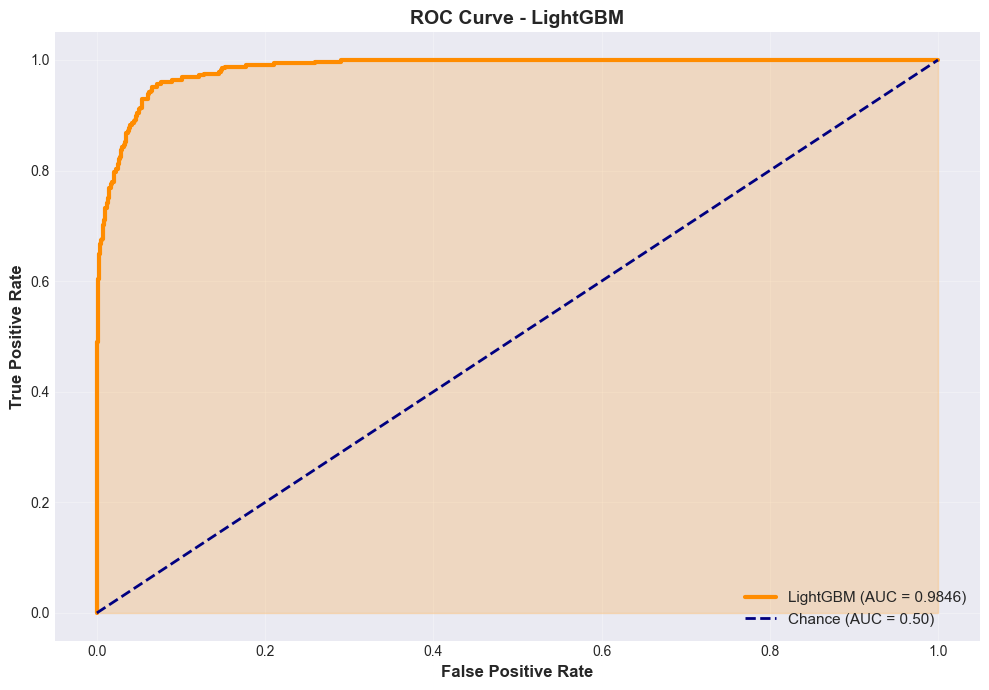

✅ AUC-ROC: 0.9846


In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'LightGBM (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / "roc_curve_reference.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ AUC-ROC: {roc_auc:.4f}")

## 12. Classification Report Detalhado

In [19]:
# Classification report
class_report = classification_report(y_test, y_pred,
                                    target_names=['Existing Customer', 'Attrited Customer'],
                                    digits=4)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(class_report)


CLASSIFICATION REPORT
                   precision    recall  f1-score   support

Existing Customer     0.9859    0.9430    0.9639      1701
Attrited Customer     0.7569    0.9292    0.8343       325

         accuracy                         0.9408      2026
        macro avg     0.8714    0.9361    0.8991      2026
     weighted avg     0.9491    0.9408    0.9431      2026



## 13. Model Versioning e Logging

In [20]:
# Initialize version manager
manager = ModelVersionManager(MODELS_PATH)

# Create metrics object
model_metrics = ModelMetrics(
    algorithm='lgbm',
    version=None,  # Auto-assigned
    auc=metrics_dict['auc'],
    accuracy=metrics_dict['accuracy'],
    precision=metrics_dict['precision'],
    recall=metrics_dict['recall'],
    f1=metrics_dict['f1'],
    notes="12-feature baseline with class_weight='balanced', 5-fold CV"
)

# Save model with versioning
model_path = manager.save_model(
    model=model,
    algorithm='lgbm',
    metrics=model_metrics,
    is_production=True  # Also save as model_final.pkl
)

print(f"\n✅ Modelo salvo com sucesso!")
print(f"   Versão: {model_metrics.version}")
print(f"   Caminho: {model_path}")

[OK] Modelo salvo: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\models\model_lgbm_v2.pkl
[OK] Métricas registradas em: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\models\versions_log.csv
[OK] Modelo de produção atualizado: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\models\model_final.pkl

✅ Modelo salvo com sucesso!
   Versão: v2
   Caminho: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\models\model_lgbm_v2.pkl


## 14. Log de Avaliação Detalhada

In [21]:
# Log evaluation
eval_file = log_evaluation(
    output_dir=TEXT_PATH,
    algorithm=f"lgbm_{model_metrics.version}",
    metrics=metrics_dict,
    report_text=class_report
)

print(f"\n✅ Avaliação registrada em: {eval_file}")

[OK] Avaliação salva em: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\text\metrics_lgbm_v2_20251210_180140.txt

✅ Avaliação registrada em: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\text\metrics_lgbm_v2_20251210_180140.txt


## 15. Histórico de Versões

In [22]:
# View all versions
versions_df = manager.list_models()
print("\n📊 Histórico de Versões:")
print(versions_df.to_string())

# Best model
best_model_data = versions_df.loc[versions_df['auc'].idxmax()]
print(f"\n🏆 Melhor modelo (por AUC):")
print(f"   {best_model_data['filename']} - AUC: {best_model_data['auc']:.4f}")


📊 Histórico de Versões:
            filename algorithm version       auc  accuracy  precision    recall        f1                   timestamp                                                        notes
0  model_lgbm_v1.pkl      lgbm      v1  0.984605   0.94077   0.756892  0.929231  0.834254  2025-12-08T18:52:59.289333             12-feature baseline with class_weight='balanced'
1  model_lgbm_v2.pkl      lgbm      v2  0.984605   0.94077   0.756892  0.929231  0.834254  2025-12-10T18:01:40.125086  12-feature baseline with class_weight='balanced', 5-fold CV

🏆 Melhor modelo (por AUC):
   model_lgbm_v1.pkl - AUC: 0.9846


## 16. Recomendações de Negócio

In [23]:
print("\n" + "="*70)
print("RECOMENDAÇÕES DE NEGÓCIO")
print("="*70)

print(f"""
🎯 PERFORMANCE DO MODELO:
   - AUC: {metrics_dict['auc']:.1%} (Excelente: >0.9)
   - Recall: {metrics_dict['recall']:.1%} (Captura {metrics_dict['recall']:.1%} dos casos de churn)
   - Precisão: {metrics_dict['precision']:.1%} (Quando prediz churn, acerta em {metrics_dict['precision']:.1%})

💡 AÇÕES RECOMENDADAS:
   1. Usar modelo em produção para identificar clientes em risco
   2. Focar em estratégias de retenção para top {metrics_dict['recall']:.0%} de casos
   3. Features críticas: Caiu_Valor, Caiu_Transacoes, Gasto_Medio_Mensal
   4. Implementar monitoramento contínuo (data drift)
   5. A/B testar estratégias de retenção por segment

📊 PRÓXIMOS PASSOS:
   ✓ Testar em webapp: streamlit run webapp/app.py
   ✓ Comparar com XGBoost e Random Forest
   ✓ Fazer SHAP analysis para explicabilidade
   ✓ Tunar hiperparâmetros com Optuna/GridSearch
   ✓ Implantar em ambiente de produção
""")

print("="*70)


RECOMENDAÇÕES DE NEGÓCIO

🎯 PERFORMANCE DO MODELO:
   - AUC: 98.5% (Excelente: >0.9)
   - Recall: 92.9% (Captura 92.9% dos casos de churn)
   - Precisão: 75.7% (Quando prediz churn, acerta em 75.7%)

💡 AÇÕES RECOMENDADAS:
   1. Usar modelo em produção para identificar clientes em risco
   2. Focar em estratégias de retenção para top 93% de casos
   3. Features críticas: Caiu_Valor, Caiu_Transacoes, Gasto_Medio_Mensal
   4. Implementar monitoramento contínuo (data drift)
   5. A/B testar estratégias de retenção por segment

📊 PRÓXIMOS PASSOS:
   ✓ Testar em webapp: streamlit run webapp/app.py
   ✓ Comparar com XGBoost e Random Forest
   ✓ Fazer SHAP analysis para explicabilidade
   ✓ Tunar hiperparâmetros com Optuna/GridSearch
   ✓ Implantar em ambiente de produção

